In [1]:
from __future__ import absolute_import, division, print_function

#@title Imports and defaults
%matplotlib inline

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import os

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

print("matplotlib %s" % mpl.__version__)

from bandits.simulator import *
from bandits.algorithms import *
from bandits.phe import *
from bandits.dropout import *

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

matplotlib 3.0.2


In [2]:
X = np.asarray([[0.9, 0.1, 1], [0.1, 0.9, 1]])
theta = np.asarray([1, 0, 0])

env = LinBandit(X, theta, "bernoulli")
print(env.print())
print(" E[r] = %s" % " ".join(["%.2f" % val for val in env.mu]))
print("a*(x) = %d" % env.best_arm)
for trial in range(5):
  env.randomize()
  print("    r = %s" % " ".join(["%.2f" % val for val in env.rt]))
print()

env = LinBandit(X, theta, "beta")
print(env.print())
print(" E[r] = %s" % " ".join(["%.2f" % val for val in env.mu]))
print("a*(x) = %d" % env.best_arm)
for trial in range(5):
  env.randomize()
  print("    r = %s" % " ".join(["%.2f" % val for val in env.rt]))

Bernoulli linear bandit: 3 dimensions, 2 arms
 E[r] = 0.90 0.10
a*(x) = 0
    r = 1.00 0.00
    r = 1.00 0.00
    r = 0.00 0.00
    r = 1.00 0.00
    r = 1.00 0.00

Beta linear bandit: 3 dimensions, 2 arms
 E[r] = 0.90 0.10
a*(x) = 0
    r = 0.89 0.01
    r = 0.99 0.00
    r = 0.91 0.25
    r = 0.92 0.01
    r = 0.93 0.06


In [ ]:
import datetime

current_dir = "./data"
reward_noise = "normal"

algs = [
  #("LinUCB", {}, "cyan", "-", "LinUCB"),
  ("LinTS", {}, "gray", "-", "LinTS"),
  #("LinGreedy", {}, "blue", "-", "$\\varepsilon$-greedy"),
  #("LinPHE", {"a": 2}, "red", "-", "LinPHE (a = 2)"),
  #("LinPHE", {"a": 1}, "darkorange", "-", "LinPHE (a = 1)"),
  ("LinPHE", {"a": 0.5}, "gold", "-", "LinPHE (a = 0.5)"),
  #("LinHistorySwap", {"swap_prob": 0.2, "swap_top": -1}, "black", "-", "LinHS (swap_prob=0.2, swap_top=-1)"),
  ("LinHistorySwap", {"swap_prob": 0.05, "swap_top": -1}, "black", "-", "LinHS (swap_prob=0.05)"),
  ("LinHistorySwap", {"swap_prob": 0., "swap_top": -1}, "darkorange", "-", "LinHS (swap_prob=0.)"),
  # ("LinHistorySwap", {"swap_prob": 0.1, "swap_top": -1}, "green", "-", "LinHS (swap_prob=0.1)"),
  # ("LinHistorySwap", {"swap_prob": 0.12, "swap_top": -1}, "blue", "-", "LinHS (swap_prob=0.12)"),
]
num_runs = 10
n = 10000
K = 50

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

plt.figure(figsize=(7.5, 2))
for fig in range(3):
  if fig == 0:
    d = 5
  elif fig == 1:
    d = 10
  else:
    d = 20

  env = []
  for run in range(num_runs):
    # standard d-dimensional basis (with a bias term)
    basis = np.eye(d)
    basis[:, -1] = 1

    # arm features in a unit (d - 2)-sphere
    X = np.random.randn(K, d - 1)
    X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
    X = np.hstack((X, np.ones((K, 1))))  # bias term
    X[: basis.shape[0], :] = basis

    # parameter vector in a (d - 2)-sphere with radius 0.5
    theta = np.random.randn(d - 1)
    theta *= 0.5 / np.sqrt(np.square(theta).sum())
    theta = np.append(theta, [0.5])

    # create environment
    env.append(LinBandit(X, theta, reward_noise))
    print("%3d: %.2f %.2f | " % (env[-1].best_arm,
      env[-1].mu.min(), env[-1].mu.max()), end="")
    if (run + 1) % 10 == 0:
      print()

  plt.subplot(1, 3, fig + 1)
  # plt.subplot(1, 1, 1)
  alg_num = 0
  for alg in algs:
    alg_class = eval(alg[0])

#     fname = "%s/lin_d=%d_%d_%s.npy" % \
#       (current_dir, d, alg_num, alg[0].lower())
#     if not os.path.exists(fname):
#       regret, _ = evaluate(alg_class, alg[1], env, n)
#       with open(fname, "wb") as f:
#         np.save(f, regret)
#     with open(fname, "rb") as f:
#       regret = np.load(f)

    regret, _ = evaluate(alg_class, alg[1], env, n)

    cum_regret = regret.cumsum(axis=0)
    std_regret = cum_regret.std(axis=1) / np.sqrt(cum_regret.shape[1])
    plt.plot(step, cum_regret.mean(axis=1),
      alg[2], dashes=linestyle2dashes(alg[3]),
      label=alg[4] if alg_num // 3 == fig else None)
    plt.fill_between(step,
      cum_regret.mean(axis=1) - std_regret,
      cum_regret.mean(axis=1) + std_regret,
      color=alg[2], alpha=0.1, linewidth=0)

    alg_num += 1

  plt.title("d = %d" % d)
  plt.xlabel("Round n")
  if not fig:
    plt.ylabel("Regret")
  #plt.ylim(0, 500 - 100 * (2 - fig))
  if fig <= 1:
    plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
# with gfile.Open("%s/LinPHE.pdf" % root_dir, "w") as f:
#   plt.savefig(f, format="pdf", dpi=1200, bbox_inches=0)
now = datetime.datetime.now()
with open("results/Lin_PHE_HS_{}_{}_{}.pdf".format(reward_noise, now.hour, now.minute), "wb") as f:
  plt.savefig(f, format="pdf", dpi=1200, bbox_inches=0)
plt.show()

 33: 0.04 0.98 |  12: 0.03 0.96 |  48: 0.09 0.94 |  20: 0.06 0.94 |  15: 0.04 0.90 |   8: 0.03 0.93 |  29: 0.03 0.98 |  17: 0.08 0.97 |  14: 0.03 0.94 |   2: 0.04 0.97 | 
 33: 0.02 0.99 |  31: 0.04 0.98 |  34: 0.06 0.96 |  43: 0.02 0.98 |   5: 0.04 0.96 |  13: 0.03 0.95 |  20: 0.03 0.91 |  14: 0.13 0.98 |  32: 0.04 0.94 |  13: 0.00 0.94 | 
Evaluating LinTS.................... 51.2 seconds
Regret: 82.20 +/- 4.41 (median: 78.50, max: 123.00, min: 45.00)
Evaluating LinPHE.................... 31.3 seconds
Regret: 63.40 +/- 2.62 (median: 63.00, max: 91.00, min: 43.00)
Evaluating LinHistory-Swapping.................... 31.6 seconds
Regret: 143.95 +/- 26.31 (median: 88.50, max: 495.00, min: 47.00)
Evaluating Lin Dropout Exploration.................... 17.9 seconds
Regret: 163.30 +/- 46.71 (median: 39.00, max: 757.00, min: 23.00)
Evaluating Lin Dropout Exploration.................... 14.3 seconds
Regret: 105.35 +/- 24.08 (median: 54.50, max: 441.00, min: 0.00)
Evaluating Lin Dropout Exploratio

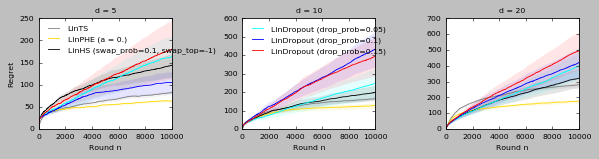

In [4]:
import datetime

current_dir = "./data"
reward_noise = "bernoulli"

algs = [
  #("LinUCB", {}, "cyan", "-", "LinUCB"),
  ("LinTS", {}, "gray", "-", "LinTS"),
  #("LinGreedy", {}, "cyan", "-", "$\\varepsilon$-greedy"),
  #("LinPHE", {"a": 2}, "red", "-", "LinPHE (a = 2)"),
  #("LinPHE", {"a": 1}, "darkorange", "-", "LinPHE (a = 1)"),
  ("LinPHE", {"a": 0.5}, "gold", "-", "LinPHE (a = 0.5)"),
  ("LinHistorySwap", {"swap_prob": 0.1, "swap_top": -1}, "black", "-", "LinHS (swap_prob=0.1, swap_top=-1)"),
  # ("LinHistorySwap", {"swap_prob": 0., "swap_top": -1}, "black", "-", "LinHS (swap_prob=0.)"),
  ("LinDropout", {"drop_prob": 0.05}, "cyan", "-", "LinDropout (drop_prob=0.05)"),
  ("LinDropout", {"drop_prob": 0.1}, "blue", "-", "LinDropout (drop_prob=0.1)"),
  ("LinDropout", {"drop_prob": 0.15}, "red", "-", "LinDropout (drop_prob=0.15)"),
  # ("LinDropout", {"drop_prob": 0.}, "blue", "-", "LinDropout (drop_prob=0.)"),
  # ("LinDropout_gradient", {"drop_prob": 0.2, "lr": 0.1}, "red", "-", "LinDropout (drop_prob=0.2)"),
  # ("LinDropout_gradient", {"drop_prob": 0.1, "lr": 0.1}, "darkgreen", "-", "LinDropout (drop_prob=0.1)"),
]

num_runs = 20
n = 10000
K = 50

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

plt.figure(figsize=(7.5, 2))
for fig in range(3):
  if fig == 0:
    d = 5
  elif fig == 1:
    d = 10
  else:
    d = 20

  env = []
  for run in range(num_runs):
    # standard d-dimensional basis (with a bias term)
    basis = np.eye(d)
    basis[:, -1] = 1

    # arm features in a unit (d - 2)-sphere
    X = np.random.randn(K, d - 1)
    X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
    X = np.hstack((X, np.ones((K, 1))))  # bias term
    X[: basis.shape[0], :] = basis

    # parameter vector in a (d - 2)-sphere with radius 0.5
    theta = np.random.randn(d - 1)
    theta *= 0.5 / np.sqrt(np.square(theta).sum())
    theta = np.append(theta, [0.5])

    # create environment
    env.append(LinBandit(X, theta, reward_noise))
    print("%3d: %.2f %.2f | " % (env[-1].best_arm,
      env[-1].mu.min(), env[-1].mu.max()), end="")
    if (run + 1) % 10 == 0:
      print()

  plt.subplot(1, 3, fig + 1)
  #plt.subplot(1, 1, 1)
  alg_num = 0
  for alg in algs:
    alg_class = eval(alg[0])

#     fname = "%s/lin_d=%d_%d_%s.npy" % \
#       (current_dir, d, alg_num, alg[0].lower())
#     if not os.path.exists(fname):
#       regret, _ = evaluate(alg_class, alg[1], env, n)
#       with open(fname, "wb") as f:
#         np.save(f, regret)
#     with open(fname, "rb") as f:
#       regret = np.load(f)

    regret, _ = evaluate(alg_class, alg[1], env, n)

    cum_regret = regret.cumsum(axis=0)
    std_regret = cum_regret.std(axis=1) / np.sqrt(cum_regret.shape[1])
    plt.plot(step, cum_regret.mean(axis=1),
      alg[2], dashes=linestyle2dashes(alg[3]),
      label=alg[4] if alg_num // 3 == fig else None)
    plt.fill_between(step,
      cum_regret.mean(axis=1) - std_regret,
      cum_regret.mean(axis=1) + std_regret,
      color=alg[2], alpha=0.1, linewidth=0)

    alg_num += 1

  plt.title("d = %d" % d)
  plt.xlabel("Round n")
  if not fig:
    plt.ylabel("Regret")
  #plt.ylim(0, 500 - 100 * (2 - fig))
  if fig <= 1:
    plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
# with gfile.Open("%s/LinPHE.pdf" % root_dir, "w") as f:
#   plt.savefig(f, format="pdf", dpi=1200, bbox_inches=0)
now = datetime.datetime.now()
with open("results/Lin_Dropout_{}_{}_{}.jpeg".format(reward_noise, now.hour, now.minute), "wb") as f:
  plt.savefig(f, format="jpeg", dpi=1200, bbox_inches=0)
plt.show()